# $ZEKROM$
$\text{Zonal Error-bound K-dimensional Reduced Order Method}$

$\text{Real title: Error control for reduced order models (a posteriori error estimator)}$

##cose

In [1]:
#@title global variables

def del_prints():
    clear_output(wait=True)
    print('Done!')

bc_str = [
    "0 * mu1 * x[0] + mu2 * x[1]",
    "mu1 * x[0] + mu2 * x[1]",
    "0 * mu1 + mu2 * sin(pi*x[0]*pi*x[1])",
    "0 * mu1 + mu2 * sin(pi*x[0])*sin(pi*x[1])",
    "0 * mu1 + mu2 * exp(-100 * ((x[0]-0.5)*(x[0]-0.5) + (x[1]-0.5)*(x[1]-0.5)))"
          ]
i=0

In [2]:
#@title import dependencies

# Installing FEniCS (dolfin) on the Google Colab servers
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
from dolfin import *

# Setting some plotting styles
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 9)

# Importing some libraries
from dolfin import * # This is the core of FEniCS and it contains all the FEM functions we will need
from ufl_legacy.geometry import * # This helps in designing geometries
from ufl_legacy import triangle
from dolfin.cpp.mesh import *     # This handles meshes
from mshr import *                # This generates meshes

import numpy as np
from scipy.linalg import svd
import scipy

from IPython.display import clear_output

del_prints()

Done!


###pipeline

1. Definizione del problema fisico
    - Problema ellittico parametrizzato (es. Poisson, conduzione, elasticità).
      - usiamo Poisson
    - Condizioni al bordo di Dirichlet non omogenee, eventualmente con una lifting function affine nel parametro.
    - Assicurarsi che sia ammissibile una decomposizione affina.

2. Implementazione base (truth model) \
  - FEM 2D con FEniCS.
  - Parametrizza uno o più aspetti del problema (coefficiente diffusivo, condizioni al bordo, forma del dominio...).

3. Costruzione del modello ridotto tramite POD o Greedy\
  - Offline stage
    - Costruzione snapshot: risolvi il problema per un insieme di parametri.
    - Costruisci la base ridotta:
      - POD: tramite SVD degli snapshot.
      - Greedy: usa un estimatore dell’errore a posteriori (da Cap. 4).
    - Ortonormalizzazione delle basi (es. Gram-Schmidt).
    - Precomputazione della decomposizione affine (matrici ridotte Aq_rb, vettori fq_rb...).

  - Online stage
    - Per ogni nuovo parametro:
    - Assemblaggio rapido della matrice ridotta.
    - Soluzione del sistema ridotto.
    - Calcolo dell’output e dell’error estimator.

4. Analisi dell’errore e certificazione\
Validare il modello ridotto e l'estimatore.
  - Plot e analisi dei risultati
  - Errore vs. numero di basi ridotte.
  - Error estimator vs. numero di basi.
  - Fissato N: errore e stimatore al variare del parametro.
  - Effetto della costante di coercività (confronta stime conservative vs. reali).
  - Indice di effectivity dell’estimatore.

5. Analisi computazionale\
Dimostrare i vantaggi del modello ridotto.
  - Benchmark di tempo
  - Tempo medio di una simulazione “truth” vs. ridotta.
  - Calcolo dello speedup.
  - Mostra la scalabilità con il numero di parametri.

## Problema fisico

Definiamo un problema fisico concreto su cui applicare la riduzione di ordine con controllo dell’errore.

Consideriamo l'equazione di Poisson 2D. la **forma forte** è descritta dal sistema

$$
\begin{cases}
- \nabla \cdot (a(x;\mu)\nabla u(x;\mu)) = f(x) & \text{in } \Omega \\
u(x;\mu) = g(x;\mu) & \text{su } \partial \Omega
\end{cases}
$$

e, dato $\mu = (\mu_1, \mu_2) \in \mathcal{P} = [0.1, 1] \times [0, 1]$, scegliamo:

- Diffusività:$\quad a(x; \mu) = 1 $\
(affine rispetto a $\mu \ \Rightarrow$ utile per la riduzione)

- Dirichlet's non-homogeneus BC:$\quad g(x;\mu) = \mu_2 x_2 $\
(affine rispetto a $\mu \ \Rightarrow$ lifting facile)

- Forzante (termine sorgente):$\quad f(x) = 1 $

\
Per gestire la non omogeneità delle condizioni al bordo utilizziamo una funzione **"Lifting"** per ricondurci al problema omogeneo, quindi:
$$
u_{\text{lift}} := g(x;\mu) \text{ su } \partial\Omega
$$
ora, definendo $ \tilde{u}(x;\mu) = u(x;\mu) - u_{\text{lift}}(x;\mu) $ otteniamo che $ \tilde{u} $ risolve il seguente sistema **omogeneo**:

$$
\begin{cases}
- \nabla \cdot (a(x;\mu)\nabla \tilde{u}(x;\mu)) = - \nabla \cdot (a(x;\mu)\nabla u(x;\mu)) = f(x) & \text{in } \Omega \\
\tilde{u}(x;\mu) = u(x;\mu) - u_{\text{lift}}(x;\mu) = g(x;\mu) - g(x;\mu) = 0 & \text{su } \partial \Omega
\end{cases}
$$

\
A questo punto possiamo passare alla **forma debole**, cioè:
Trova $\tilde{u}(\mu) \in H_0^1(\Omega)$ tale che:

$$
\int_\Omega a(x;\mu) \nabla \tilde{u} \cdot \nabla v \ dx + \int_\Omega a(x;\mu) \nabla u_{\text{lift}} \cdot \nabla v \ dx = \int_\Omega f v \ dx,  \quad \forall v \in H_0^1(\Omega)
$$
(ricordando che $ u = \tilde{u} + u_{lift} $)


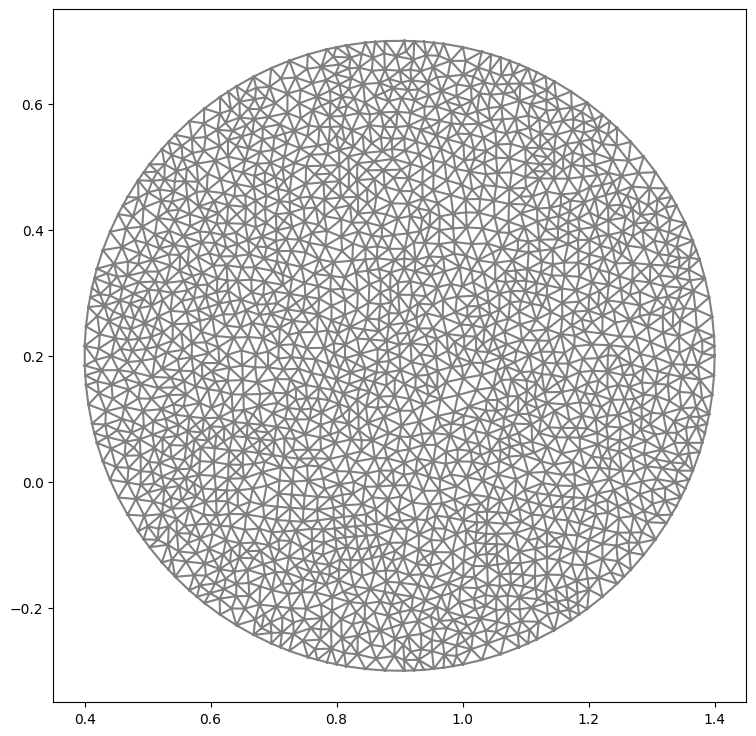

In [3]:
#@title Definizione della geometria $\Omega$
# costruiamo la nostra geometria e generiamo la mesh con circa
# 32 elementi per lato (triangoli di default)
#Omega = Rectangle(Point(0, 0), Point(1, 1))
Omega = Circle(Point(0.9, 0.2),0.5)
#Omega = Omega - Circle(Point(0.9, 0.2),0.5)

mesh_ = generate_mesh(Omega, 32)
plot(mesh_)

In [4]:
#@title Definiamo $ \langle \varphi_i \rangle $  e  $ V_h $ con $ \varphi_i \in \mathbb{P}^1 $
# definiamo le nostre funzioni di base (lagrangiane) sul nostro elemento finito
V_element = FiniteElement('Lagrange', triangle, 1)
V = FunctionSpace(mesh_, V_element) # = V_h
del_prints()

Done!


In [5]:
#@title $v$ ed $u$
# a questo punto:
# definiamo le funzioni trial che useremo nel posto dell'incognita u del sistema lineare
# definiamo le funzioni test con il quale testiamo il problema
u = TrialFunction(V) # corrispondono alle colonne del sistema
v = TestFunction(V)  # corrispondono alle righe del sistema

In [6]:
#@title Parametro $\mu$
mu1 = Constant(1.0)
mu2 = Constant(1.0)

mu1.assign(0.5)
mu2.assign(0.15)

In [7]:
#@title Boundary conditions
# definiamo prima la nostra funzione g
g_expr = Expression(bc_str[i+1], degree=2, mu1=mu1, mu2=mu2)
a_expr = Expression('1', degree=1)

BC = DirichletBC(V, g_expr, "on_boundary")

print("usiamo condizioni al bordo g = " + bc_str[i])

usiamo condizioni al bordo g = 0 * mu1 * x[0] + mu2 * x[1]


### Considerazioni

Il problema è **coercivo** (Poisson su dominio limitato con $a(x;\mu) \geq 0.1$) \
- Ricordiamo che:\
data una forma bilineare $a(u,v;\mu)$ diciamo che questa è coerciva se $a(u,v;\mu) \geq \alpha(\mu) \ ||v||^2_{H_0^1}$ con $\alpha(\mu)$coefficiente di coercività.
- in altre parole:
  - $a(\cdot,\cdot;\mu)$ controlla la norma $ ||v||$
  - Nessuna "direzione" di $v$ può sfuggire al controllo (nessuna degenerazione)

\
Nel nostro caso abbiamo:

1. $a(x;\mu) \geq \underline{a} > 0$ per ogni $x \in \Omega$, $\mu \in \mathcal{P}$  
   - $ a(x;\mu) = 1 \geq 1 \Rightarrow \alpha(\mu) \geq 1$

2. Il dominio $\Omega$ è limitato e regolare, quindi:
   - Poincaré: $\|v\|_{L^2} \leq C \|\nabla v\|$ \
   $\Rightarrow$ la norma $H^1_0$ è equivalente a $\|\nabla v\|$

3. La forma bilineare è:
   $$
   a(u,v;\mu) = \int_\Omega a(x;\mu) \nabla u \cdot \nabla v \, dx
   $$
   che è **simmetrica**, **positiva definita**, e **uniformemente ellittica**

\
Otteniamo quindi:
- Esistenza e unicità della soluzione per il teorema di Lax-Milgram
- Stabilità numerica per Finite Element Method (FEM)
- Errori stimabili a posteriori
- RBM certificabile cioè è possibile stimare l’errore tra soluzione ridotta e completa
- Convergenza garantita: Greedy converge rapidamente se l'errore è controllato da coercività

\

Obiettivo nel contesto RBM

- Costruire base ridotta (POD o greedy)
- Stimare errore e certificare $\eta(\mu)$
- Visualizzare:
  - errore vs. $N$ basi
  - errore/estimatore vs. parametro
  - speedup vs. full FEM

## FEM

A questo punto riscriviamo la PDE
$$
\begin{cases}
- \Delta u = f \quad & \text{in} \ \Omega \\
u = g \quad & \text{in} \ \partial \Omega
\end{cases}
$$
come
$$
u = w + u_{lift}
$$
dove $\quad w|_{\partial \Omega} = 0 \quad \text{ e } \quad u_{lift}|_{\partial \Omega} = g$
per poi risolvere la PDE usando
$$
- \Delta w = f + \Delta u_{lift} \quad \text{in} \ \Omega, \quad w|_{\partial \Omega} = 0
$$

In [8]:
#@title Assemblaggio del problema con lifting

# definiamo la funzione lifting u_lift, tc u_lift = g su ∂Ω
u_lift = TrialFunction(V) # soddisfa la BC g

# risolviamo -Δ(u_lift) = 0 with u_lift = g on ∂Ω
lhs_lift = a_expr * inner(grad(u_lift), grad(v)) * dx
rhs_lift = Constant(0.0) * v * dx

LHS_lift = assemble(lhs_lift)
RSH_lift = assemble(rhs_lift)

BC.apply(LHS_lift)
BC.apply(RSH_lift)

del_prints()

Done!


In [9]:
print(type(LHS_lift), type(u_lift), type(RSH_lift))

<class 'dolfin.cpp.la.Matrix'> <class 'dolfin.function.argument.Argument'> <class 'dolfin.cpp.la.Vector'>


In [10]:
#@title Risoluzione del problema con lifting
ul_sol = Function(V)
solve(LHS_lift, ul_sol.vector(), RSH_lift)

1

In [11]:
#@title Right-hand side del problema omogeneo $f + Δ(u_{lift}) = f - \nabla \cdot ( \nabla u_{lift})$
f = Constant(1.0)
laplacian_u_lift = -div(grad(ul_sol))
rhs_expr = f + laplacian_u_lift

In [12]:
#@title Calcolo RHS e LHS per $w:=\tilde{u}$ e risoluzione del problema
# Risolvo per w in: -Δw = f + Δ(u_lift), w = 0 su ∂Ω
w = TrialFunction(V)
lhs_w = a_expr * inner(grad(w), grad(v)) * dx
rhs_w = rhs_expr * v * dx

LHS_w = assemble(lhs_w)
RHS_w = assemble(rhs_w)

zero_BC = DirichletBC(V, 0.0, "on_boundary")
zero_BC.apply(LHS_w)
zero_BC.apply(RHS_w)

w_sol = Function(V)
solve(LHS_w, w_sol.vector(), RHS_w)

del_prints()

Done!


In [13]:
#@title unione dei due risultati
# calcolo soluzione finale: u = w + u_lift
u_sol = Function(V)
u_sol.vector()[:] = w_sol.vector() + ul_sol.vector()

### Plot delle soluzioni $ u_{lift}, \, w (=\tilde{u}), \, u $

In [14]:
#@title plotting function
def plottiaml(sol_list, titles=None):
    n = len(sol_list)
    if n == 0:
        print("La lista delle soluzioni è vuota.")
        return

    n_cols = min(n, 3)           # massimo 3 colonne
    n_rows = int(np.ceil(n / 3)) # tante righe quante servono

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

    if n_rows == 1:
        axes = np.atleast_1d(axes)
    else:
        axes = axes.flatten()

    for i in range(n):
        plt.sca(axes[i])
        p = plot(sol_list[i])
        if titles is not None and i < len(titles):
            axes[i].set_title(titles[i])
        plt.colorbar(p)

    # Disattiva subplot vuoti
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

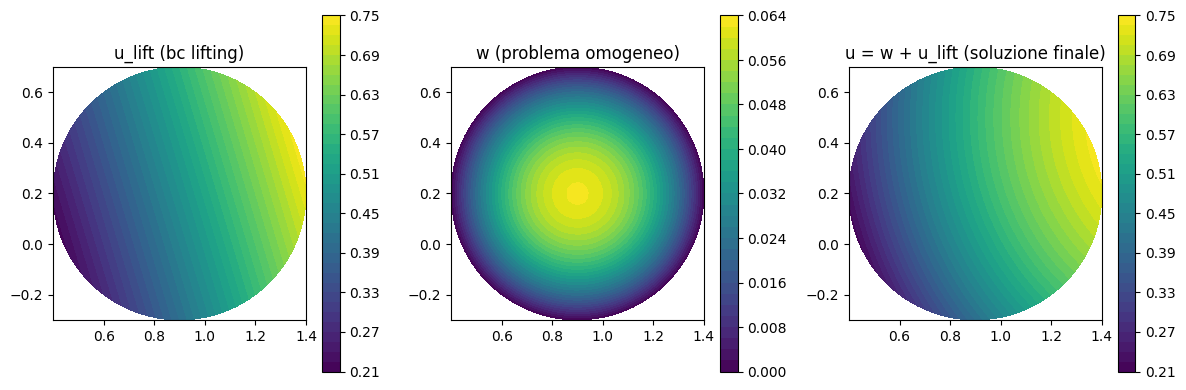

In [15]:
plottiaml(
    [ul_sol, w_sol, u_sol],
    titles=["u_lift (bc lifting)", "w (problema omogeneo)", "u = w + u_lift (soluzione finale)"]
)

In [16]:
N_dofs = len(u_sol.vector())
N_dofs

2079

In [17]:
#@title Truth solver (compressione di tutto in una funzione)

def solve_for(Omega, mu1_val,mu2_val):

    mesh = generate_mesh(Omega, 32)

    # definiamo le nostre funzioni di base (lagrangiane) sul nostro elemento finito
    V_element = FiniteElement('Lagrange', triangle, 1)
    V = FunctionSpace(mesh, V_element) # = V_h

    u = TrialFunction(V)
    v = TestFunction(V)

    mu1 = Constant(1.0)
    mu2 = Constant(1.0)

    mu1.assign(mu1_val)
    mu2.assign(mu2_val)
    g_expr = Expression(bc_str[i+1], degree=2, mu1=mu1, mu2=mu2)
    a_expr = Expression('1', degree=1)
    BC = DirichletBC(V, g_expr, "on_boundary")

    # definiamo la funzione lifting u_lift, tc u_lift = g su ∂Ω
    u_lift = TrialFunction(V)

    # risolviamo -Δ(u_lift) = 0 with u_lift = g on ∂Ω
    lhs_lift = a_expr * inner(grad(u_lift), grad(v)) * dx
    rhs_lift = Constant(0.0) * v * dx

    LHS_lift = assemble(lhs_lift)
    RSH_lift = assemble(rhs_lift)

    BC.apply(LHS_lift)
    BC.apply(RSH_lift)

    ul_sol = Function(V)
    solve(LHS_lift, ul_sol.vector(), RSH_lift)

    f = Constant(1.0)
    laplacian_u_lift = -div(grad(ul_sol))
    rhs_expr = f + laplacian_u_lift

    w = TrialFunction(V)
    lhs_w = a_expr * inner(grad(w), grad(v)) * dx
    rhs_w = rhs_expr * v * dx

    LHS_w = assemble(lhs_w)
    RHS_w = assemble(rhs_w)

    zero_BC = DirichletBC(V, 0.0, "on_boundary")
    zero_BC.apply(LHS_w)
    zero_BC.apply(RHS_w)

    w_sol = Function(V)
    solve(LHS_w, w_sol.vector(), RHS_w)

    # calcolo soluzione finale: u = w + u_lift
    u_sol = Function(V)
    u_sol.vector()[:] = w_sol.vector() + ul_sol.vector()

    del_prints()

    return ul_sol.copy(deepcopy=True), w_sol.copy(deepcopy=True), u_sol.copy(deepcopy=True)

In [18]:
ul_sol, w_sol, u_sol = solve_for(Omega,
                   mu1_val = 0.5   ,
                   mu2_val = 0.15,
                   )
#plottiaml([ul_sol, w_sol, u_sol]) # per controllare che dia lo stesso risultato in caso di diffidenza

Done!


##RBM

### Offline stage

Costruiamo il **manifold delle soluzioni**:

$$
\mathcal{M}_\delta = \{ u_\delta(\mu) \mid \mu \in \mathcal{P} \}
$$

dove ogni $u_\delta(\mu)$ è ottenuta risolvendo il problema completo per un parametro $\mu = (\mu_1, \mu_2)$ nel sottospazio scelto dallo spazio dei parametri. Queste soluzioni si chiamano **snapshots**.


In [19]:
mus = np.array([[m1, m2] for m1 in np.linspace(-1, 1, 11)
                   for m2 in np.linspace(-1, 1, 11)])
M = len(mus)
M

121

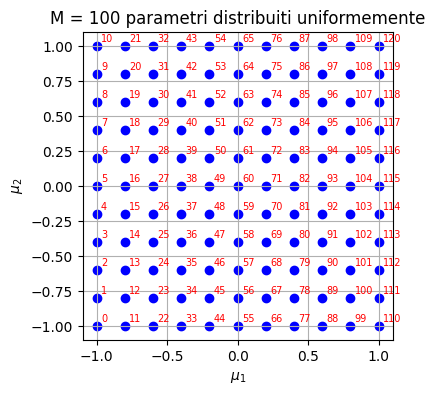

In [20]:
#@title visualizzazione
plt.figure(figsize=(4, 4))
plt.scatter(mus[:, 0], mus[:, 1], c='blue', label='Parametri selezionati')
for k, (x, y) in enumerate(mus):
    plt.text(x + 0.03, y + 0.03, str(k), fontsize=7, color='red')
plt.grid(True)
plt.title("M = 100 parametri distribuiti uniformemente")
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.show()

In [21]:
#@title Costruiamo la matrice $U$ di snapshots con dimensionalità $ \ N_{dofs} \times M$
U = np.zeros(shape=(N_dofs,M))
j = 0
for m1, m2 in mus:
    _, _, u_sol = solve_for(Omega, m1, m2)
    U[:,j]=u_sol.vector().get_local()
    j+=1

Done!


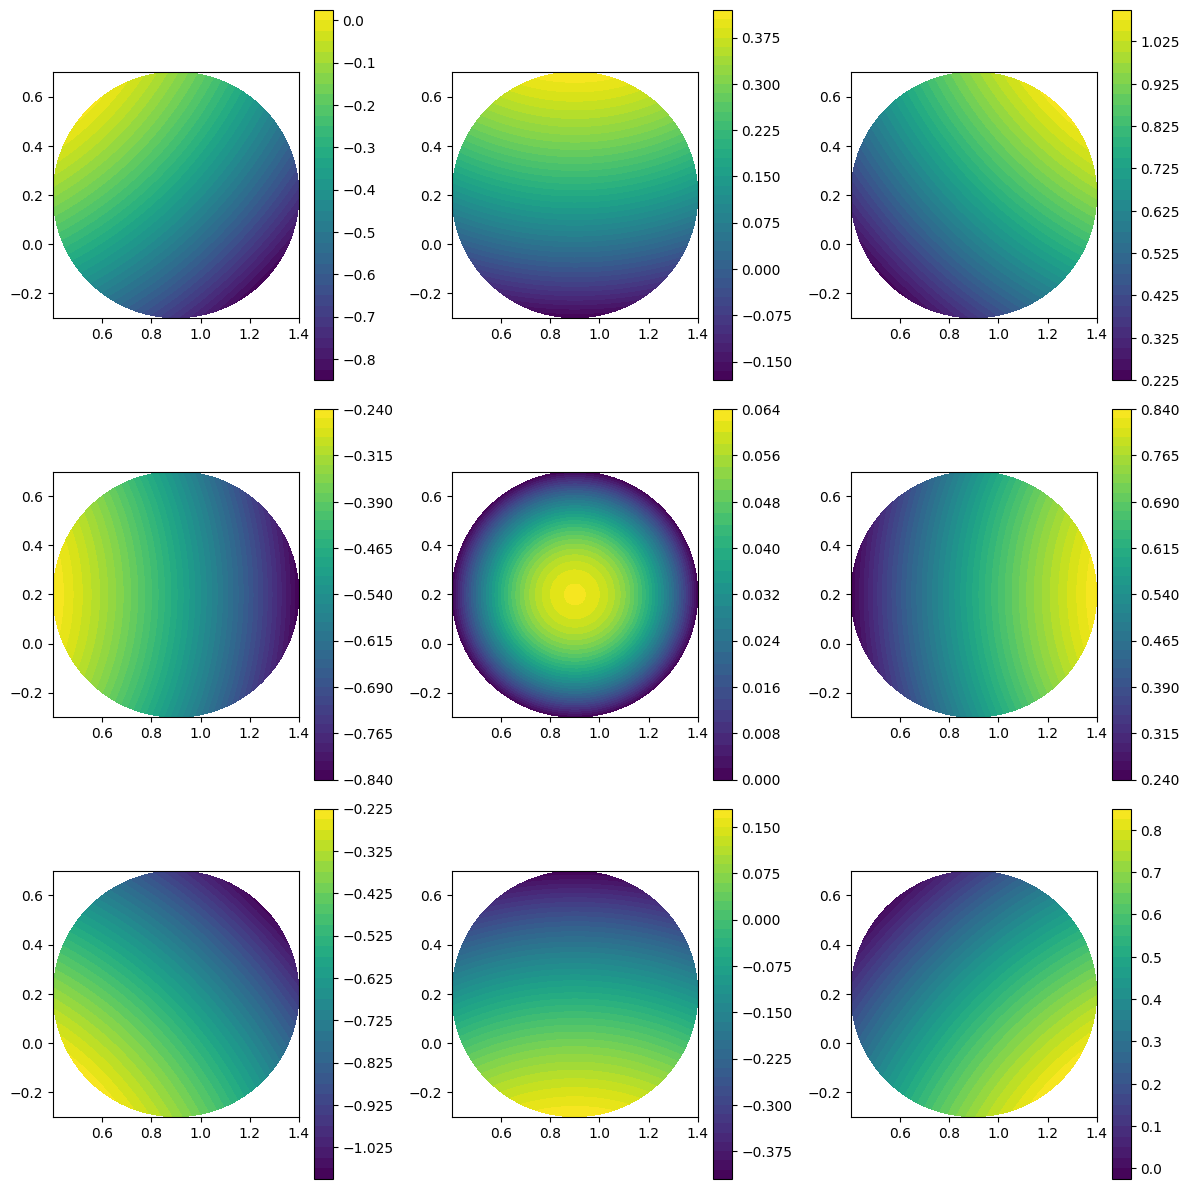

In [23]:
#@title visualizziamo le soluzioni trovate
# siamo passati da  u_sol -----------------------------> u_sol.vector() -------------> u_sol.vector().get_local())
#        quindi da 'dolfin.function.function.Function'->'dolfin.cpp.la.PETScVector'->'numpy.ndarray'
# torniamo da class 'numpy.ndarray a class 'dolfin.function.function.Function'>
u1, u2, u3, u4, u5, u6, u7, u8, u9 = Function(V), Function(V), Function(V), Function(V), Function(V), Function(V), Function(V), Function(V), Function(V)
u1.vector().set_local(U[:,30]); u1.vector().apply("insert")
u2.vector().set_local(U[:,63]); u2.vector().apply("insert")
u3.vector().set_local(U[:,96]); u3.vector().apply("insert")
u4.vector().set_local(U[:,27]); u4.vector().apply("insert")
u5.vector().set_local(U[:,60]); u5.vector().apply("insert")
u6.vector().set_local(U[:,93]); u6.vector().apply("insert")
u7.vector().set_local(U[:,24]); u7.vector().apply("insert")
u8.vector().set_local(U[:,57]); u8.vector().apply("insert")
u9.vector().set_local(U[:,90]); u9.vector().apply("insert")

plottiaml([u1, u2, u3, u4, u5, u6, u7, u8, u9])

Ora utilizziamo la **Proper Orthogonal Decomposition (POD)** per ottenere una base ridotta ottimale nel senso $L^2$.

Si considera la matrice dei dati:

$$
U = [u_\delta(\mu_1), u_\delta(\mu_2), \ldots, u_\delta(\mu_M)] \in \mathbb{R}^{N_\delta \times M}
$$

e si effettua la decomposizione SVD:

$$
U = W \Sigma V^T
$$

Gli autovettori singolari sinistri $\xi_i$ (colonne di $U_{svd} := W$) sono le funzioni base e proendendo i primi $K$ formiamo la base ridotta:

$$
V_{\text{rb}} = \text{span}\{\xi_1, \ldots, \xi_K\}
$$

che minimizza l'errore medio tra gli snapshot e le loro proiezioni.


In [24]:
# Eseguiamo la SVD
U_mean = np.mean(U, axis=1, keepdims=True)
U_centered = U - U_mean
U_svd, S, VT = svd(U_centered, full_matrices=False)
print(U.shape)

# Numero di funzioni base ridotte da conservare
K = 5
RB = U_svd[:, :K]  # colonne = basi ridotte

print(f"Costruito spazio ridotto con {K} basi su {U.shape[0]} DOF originali.")

(2079, 121)
Costruito spazio ridotto con 5 basi su 2079 DOF originali.


###Offline stage

Dato il sottospazio ridotto $V_{\text{rb}} = \text{span}\{\xi_1, \dots, \xi_K\}$, si cerca $u_{\text{rb}}(\mu) \in V_{\text{rb}}$ tale che soddisfi la **proiezione di Galerkin**, cioè tale che:

$$
a(u_{\text{rb}}(\mu), v; \mu) = f(v; \mu) \quad \forall v \in V_{\text{rb}}
$$

In pratica, il problema viene proiettato sulla base ridotta, riducendo drasticamente il costo computazionale.


Risolutore approssimativo

In [25]:
def solve_online(mu1, mu2, RB, mesh):
    V = FunctionSpace(mesh, 'P', 1)
    u = TrialFunction(V)
    v = TestFunction(V)

    #definizione problema parametrico
    a_form = inner(grad(u), grad(v))*dx + mu1*u*v*dx
    f_expr = Constant(mu1 + mu2)
    L_form = f_expr*v*dx

    #condizioni omogene al bordo
    bc = DirichletBC(V, Constant(0.0), "on_boundary")

    #assembla sistema
    A, f = assemble_system(a_form, L_form, bc)

    #conversione in numpy
    A_csr = as_backend_type(A).mat().getValuesCSR()
    A_mat = scipy.sparse.csr_matrix((A_csr[2], A_csr[1], A_csr[0]))
    f_vec = f.get_local()

    #proiezione del sistema nello spazio ridotto
    A_N = RB.T @ A_mat @ RB
    f_N = RB.T @ f_vec
    u_N_coeffs = np.linalg.solve(A_N, f_N)

    # ricostruiamo la soluzione approssimata
    u_approx = RB @ u_N_coeffs

    del_prints()
    return u_approx


In [26]:
mu1_test = 0.2
mu2_test = 0.15
print(type(mu1_test))
print(type(mu2_test))
print(type(RB))
print(type(mesh_))

<class 'float'>
<class 'float'>
<class 'numpy.ndarray'>
<class 'dolfin.cpp.mesh.Mesh'>


In [27]:
u_approx = solve_online(mu1_test, mu2_test, RB, mesh_)
print(u_approx)

Done!
[ 2.88122342e-04 -6.61884137e-05  2.32823662e-04 ...  6.00715396e-04
  5.83251184e-04  5.87612741e-04]


Stima dell'errore tramite residuo:

Per un problema coercivo si può stimare l'errore nella norma energetica:

$$
\| u_\delta(\mu) - u_{\text{rb}}(\mu) \|_V \leq \frac{ \| r(\cdot; \mu) \|_{V'} }{ \sqrt{ \alpha_{\text{LB}}(\mu) } }
$$

dove $r(\cdot; \mu)$ è il **residuo**:

$$
r(v; \mu) = f(v; \mu) - a(u_{\text{rb}}(\mu), v; \mu)
$$

e $\alpha_{\text{LB}}(\mu)$ è un lower bound della costante di coercività. In molti casi può essere noto o stimato tramite **min-theta** o **SCM**.


In [30]:
def test_rbm_accuracy(RB, mesh, n_tests=5):
    errors = []
    test_params = []

    for _ in range(n_tests):
        mu1 = np.random.uniform(-1, 1)
        mu2 = np.random.uniform(-1, 1)
        test_params.append((mu1, mu2))

        V = FunctionSpace(mesh, "P", 1)

        u = TrialFunction(V)
        v = TestFunction(V)
        a_form = inner(grad(u), grad(v))*dx + mu1*u*v*dx
        L_form = Constant(mu1 + mu2)*v*dx
        bc = DirichletBC(V, Constant(0.0), "on_boundary")

        A, f = assemble_system(a_form, L_form, bc)
        u_full = Function(V)
        solve(A, u_full.vector(), f)
        u_full_vec = u_full.vector().get_local()

        u_rb = solve_online(mu1, mu2, RB, mesh)
        u_rb_vec = u_rb#.vector().get_local() # è gia vettore

        err = np.linalg.norm(u_full_vec - u_rb_vec) / np.linalg.norm(u_full_vec)
        errors.append(err)

    # statistiche
    err_mean = np.mean(errors)
    err_max = np.max(errors)
    err_min = np.min(errors)

    print("Test RBM vs Full-Order")
    for i, (mu1, mu2) in enumerate(test_params):
        print(f"Test {i+1}: mu1 = {mu1:.4f}, mu2 = {mu2:.4f} --> errore relativo = {errors[i]:.2e}")

    print("\nStatistiche errori:")
    print(f"Errore medio   : {err_mean:.2e}")
    print(f"Errore massimo : {err_max:.2e}")
    print(f"Errore minimo  : {err_min:.2e}")

    return test_params, errors


In [29]:
test_params, errors = test_rbm_accuracy(RB, mesh_, n_tests=5)

errors = np.array(errors)

errore_medio   = np.mean(errors)
errore_massimo = np.max(errors)
errore_minimo  = np.min(errors)

print("Analisi statistica degli errori:")
print(f"Errore medio   : {errore_medio:.2e}")
print(f"Errore massimo : {errore_massimo:.2e}")
print(f"Errore minimo  : {errore_minimo:.2e}")

Done!
Test RBM vs Full-Order
Test 1: mu1 = -0.6712, mu2 = -0.4268 --> errore relativo = 9.71e-01
Test 2: mu1 = -0.0687, mu2 = -0.5384 --> errore relativo = 9.70e-01
Test 3: mu1 = -0.5265, mu2 = 0.3747 --> errore relativo = 9.71e-01
Test 4: mu1 = -0.5572, mu2 = -0.2363 --> errore relativo = 9.71e-01
Test 5: mu1 = -0.3372, mu2 = -0.2116 --> errore relativo = 9.71e-01

Statistiche errori:
Errore medio   : 9.71e-01
Errore massimo : 9.71e-01
Errore minimo  : 9.70e-01
Analisi statistica degli errori:
Errore medio   : 9.71e-01
Errore massimo : 9.71e-01
Errore minimo  : 9.70e-01
